In [1]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import warnings

warnings.filterwarnings('ignore')



In [3]:
# Data import with specified encoding
movie_data = pd.read_csv(r"C:\Users\lubna\OneDrive\Desktop\IMDb_Movies_India.csv", encoding='latin1')


In [4]:
# Data Preprocessing
# Handling missing values
movie_data = movie_data.dropna()

In [5]:
# Removing duplicates
movie_data = movie_data.drop_duplicates()

In [6]:
# Extracting numerical duration from 'Duration' column
movie_data['Duration'] = movie_data['Duration'].str.replace(' min', '').astype(int)


In [7]:
# Extract numeric values from 'Year' column
movie_data['Year'] = movie_data['Year'].str.extract('(\d+)').astype(float).abs()

print(movie_data)

                                     Name    Year  Duration  \
1      #Gadhvi (He thought he was Gandhi)  2019.0       109   
3                                 #Yaaram  2019.0       110   
5                    ...Aur Pyaar Ho Gaya  1997.0       147   
6                               ...Yahaan  2005.0       142   
8                      ?: A Question Mark  2012.0        82   
...                                   ...     ...       ...   
15493                              Zubaan  2015.0       115   
15494                            Zubeidaa  2001.0       153   
15503                     Zulm Ki Zanjeer  1989.0       125   
15505                               Zulmi  1999.0       129   
15508                        Zulm-O-Sitam  1998.0       130   

                           Genre  Rating  Votes         Director  \
1                          Drama     7.0      8    Gaurav Bakshi   
3                Comedy, Romance     4.4     35       Ovais Khan   
5         Comedy, Drama, Musical     4.

In [8]:
# Check column types and convert if necessary
if not pd.api.types.is_string_dtype(movie_data['Duration']):
    movie_data['Duration'] = movie_data['Duration'].astype(str)
if not pd.api.types.is_string_dtype(movie_data['Votes']):
    movie_data['Votes'] = movie_data['Votes'].astype(str)

# Remove commas and convert to numeric
movie_data['Duration'] = movie_data['Duration'].str.replace(',', '').astype(float)
movie_data['Votes'] = movie_data['Votes'].str.replace(',', '').astype(float)

# Scaling using StandardScaler
scaler = StandardScaler()
movie_data[['Duration', 'Votes']] = scaler.fit_transform(movie_data[['Duration', 'Votes']])

print(movie_data)

                                     Name    Year  Duration  \
1      #Gadhvi (He thought he was Gandhi)  2019.0 -0.965298   
3                                 #Yaaram  2019.0 -0.925800   
5                    ...Aur Pyaar Ho Gaya  1997.0  0.535628   
6                               ...Yahaan  2005.0  0.338138   
8                      ?: A Question Mark  2012.0 -2.031745   
...                                   ...     ...       ...   
15493                              Zubaan  2015.0 -0.728310   
15494                            Zubeidaa  2001.0  0.772617   
15503                     Zulm Ki Zanjeer  1989.0 -0.333329   
15505                               Zulmi  1999.0 -0.175337   
15508                        Zulm-O-Sitam  1998.0 -0.135839   

                           Genre  Rating     Votes         Director  \
1                          Drama     7.0 -0.197040    Gaurav Bakshi   
3                Comedy, Romance     4.4 -0.195062       Ovais Khan   
5         Comedy, Drama, Music

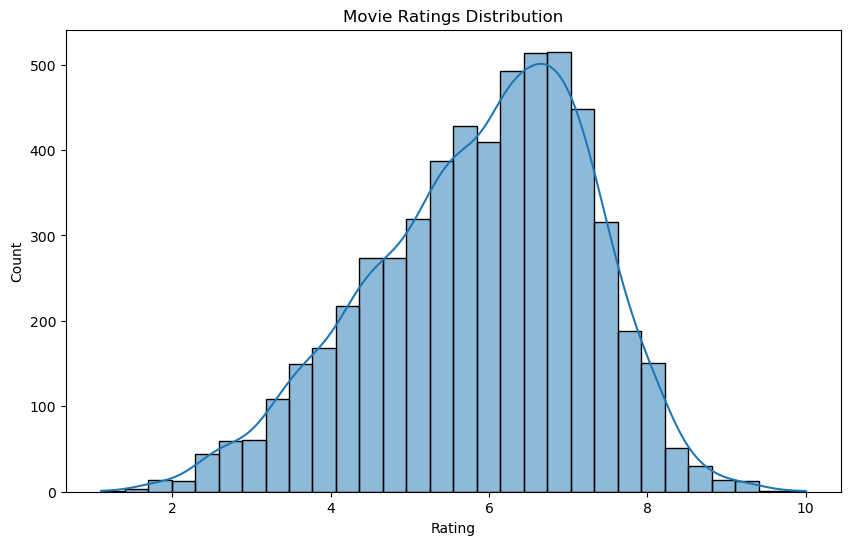

In [9]:
# Exploratory Data Analysis (EDA)
# Visualizing the distribution of ratings
plt.figure(figsize=(10, 6))
sns.histplot(movie_data['Rating'], bins=30, kde=True)
plt.title('Movie Ratings Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()



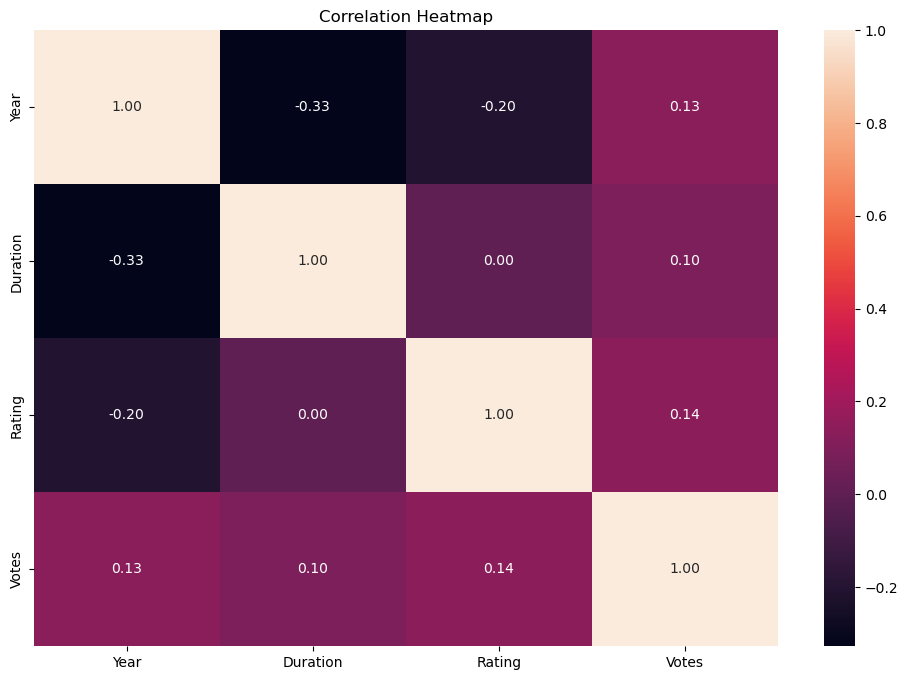

In [10]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(movie_data.corr(), annot=True, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()



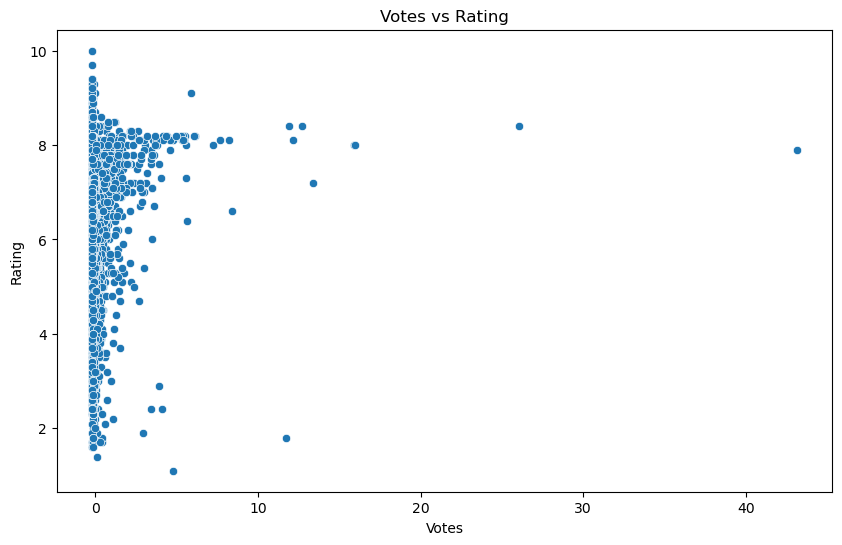

In [11]:
# Feature-Target Relationships
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Votes', y='Rating', data=movie_data)
plt.title('Votes vs Rating')
plt.xlabel('Votes')
plt.ylabel('Rating')
plt.show()



In [12]:
# Encoding categorical variables
label_encoder = LabelEncoder()
movie_data['Genre'] = label_encoder.fit_transform(movie_data['Genre'])
movie_data['Director'] = label_encoder.fit_transform(movie_data['Director'])
movie_data['Actor 1'] = label_encoder.fit_transform(movie_data['Actor 1'])
movie_data['Actor 2'] = label_encoder.fit_transform(movie_data['Actor 2'])
movie_data['Actor 3'] = label_encoder.fit_transform(movie_data['Actor 3'])

print(movie_data)

                                     Name    Year  Duration  Genre  Rating  \
1      #Gadhvi (He thought he was Gandhi)  2019.0 -0.965298    229     7.0   
3                                 #Yaaram  2019.0 -0.925800    184     4.4   
5                    ...Aur Pyaar Ho Gaya  1997.0  0.535628    157     4.7   
6                               ...Yahaan  2005.0  0.338138    289     7.4   
8                      ?: A Question Mark  2012.0 -2.031745    320     5.6   
...                                   ...     ...       ...    ...     ...   
15493                              Zubaan  2015.0 -0.728310    229     6.1   
15494                            Zubeidaa  2001.0  0.772617    133     6.2   
15503                     Zulm Ki Zanjeer  1989.0 -0.333329     28     5.8   
15505                               Zulmi  1999.0 -0.175337     38     4.5   
15508                        Zulm-O-Sitam  1998.0 -0.135839     38     6.2   

          Votes  Director  Actor 1  Actor 2  Actor 3  
1     -0

In [13]:
# Model Selection and Training
# Splitting data
features = movie_data.drop(['Rating', 'Name'], axis=1)
target = movie_data['Rating']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)



In [14]:
# Model Training with Cross-Validation
xgb_model = XGBRegressor()
cross_val_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='r2')
print('Cross-Validation R2 Scores:', cross_val_scores)
print('Mean Cross-Validation R2 Score:', np.mean(cross_val_scores))



Cross-Validation R2 Scores: [0.32226315 0.24652226 0.34998672 0.35094231 0.31998875]
Mean Cross-Validation R2 Score: 0.3179406385330892


In [15]:
# Model Evaluation
xgb_model.fit(X_train, y_train)
predictions = xgb_model.predict(X_test)
print('R2 Score:', r2_score(y_test, predictions))
print('Mean Squared Error:', mean_squared_error(y_test, predictions))
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, predictions)))


R2 Score: 0.29005355583973214
Mean Squared Error: 1.3146388170672
Mean Absolute Error: 0.8596618867173212
Root Mean Squared Error: 1.1465770000602664


In [16]:
# Model Tuning using Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7]
}
grid_search = GridSearchCV(estimator=XGBRegressor(), param_grid=param_grid, cv=3, scoring='r2')
grid_search.fit(X_train, y_train)
print('Best Params:', grid_search.best_params_)



Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


In [17]:
# Training final model with best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)
final_predictions = best_model.predict(X_test)
print('Final Model R2 Score:', r2_score(y_test, final_predictions))
print('Final Model Mean Squared Error:', mean_squared_error(y_test, final_predictions))
print('Final Model Mean Absolute Error:', mean_absolute_error(y_test, final_predictions))
print('Final Model Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, final_predictions)))



Final Model R2 Score: 0.3404202202318072
Final Model Mean Squared Error: 1.2213726663023536
Final Model Mean Absolute Error: 0.8341580796157513
Final Model Root Mean Squared Error: 1.1051573038723281


In [18]:
# Model Training and Evaluation with Random Forest
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
print('Random Forest Model Evaluation:')
print('R2 Score:', r2_score(y_test, rf_predictions))
print('Mean Squared Error:', mean_squared_error(y_test, rf_predictions))
print('Mean Absolute Error:', mean_absolute_error(y_test, rf_predictions))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, rf_predictions)))



Random Forest Model Evaluation:
R2 Score: 0.31408612257715474
Mean Squared Error: 1.2701366643109544
Mean Absolute Error: 0.8528162544169613
Root Mean Squared Error: 1.1270034003102893


In [19]:
# Model Tuning using Grid Search for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid_rf, cv=3, scoring='r2')
grid_search_rf.fit(X_train, y_train)
print('Best Params for Random Forest:', grid_search_rf.best_params_)



Best Params for Random Forest: {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 200}


In [20]:
# Training final Random Forest model with best parameters
best_rf_model = grid_search_rf.best_estimator_
best_rf_model.fit(X_train, y_train)
final_rf_predictions = best_rf_model.predict(X_test)
print('Final Random Forest Model Evaluation:')
print('R2 Score:', r2_score(y_test, final_rf_predictions))
print('Mean Squared Error:', mean_squared_error(y_test, final_rf_predictions))
print('Mean Absolute Error:', mean_absolute_error(y_test, final_rf_predictions))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, final_rf_predictions)))



Final Random Forest Model Evaluation:
R2 Score: 0.31740962848265497
Mean Squared Error: 1.2639823833675647
Mean Absolute Error: 0.8507446614932136
Root Mean Squared Error: 1.124269711131437


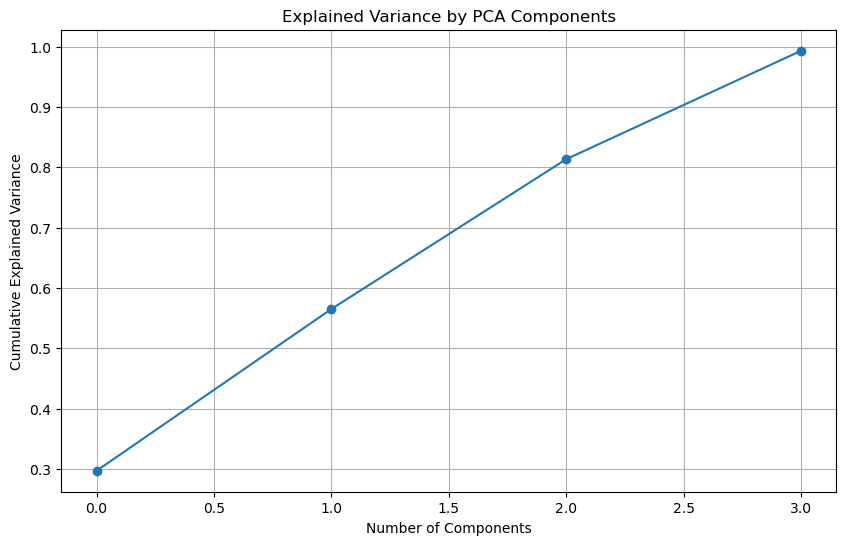

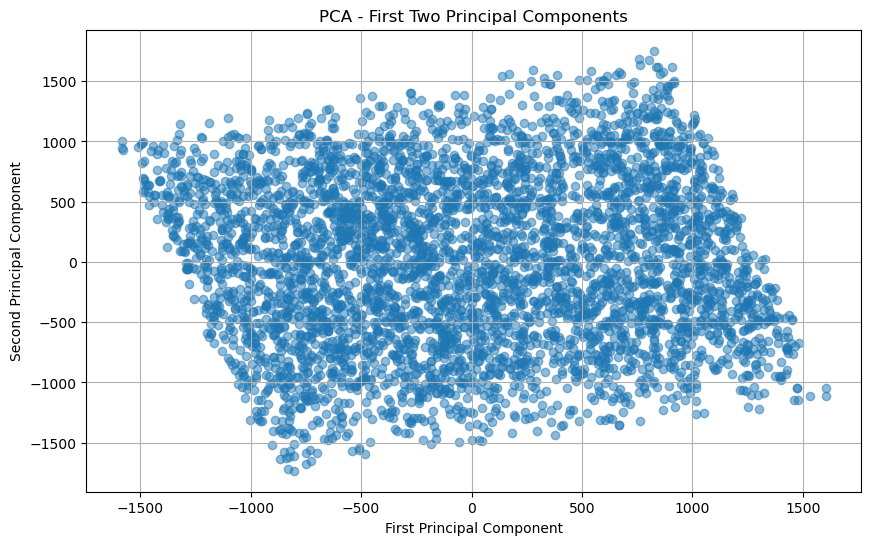

In [22]:
from sklearn.decomposition import PCA

# Applying PCA
pca = PCA(n_components=0.95)  # Keeping 95% of the variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Plotting the explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

# Plotting the first two principal components
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], alpha=0.5)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA - First Two Principal Components')
plt.grid(True)
plt.show()

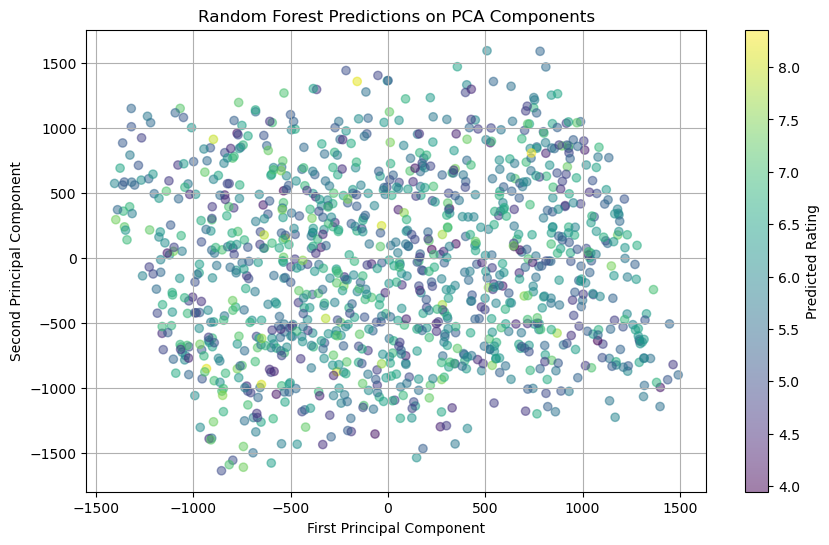

In [23]:
# Plotting the first two principal components with model predictions (for Random Forest as an example)
plt.figure(figsize=(10, 6))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=rf_predictions, cmap='viridis', alpha=0.5)
plt.colorbar(label='Predicted Rating')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Random Forest Predictions on PCA Components')
plt.grid(True)
plt.show()

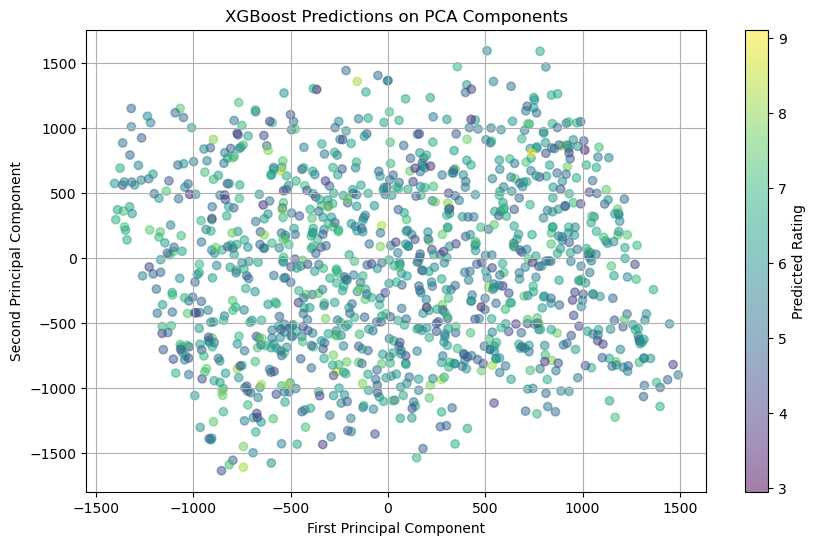

In [25]:
# Plotting the first two principal components with model predictions (for Random Forest as an example)
plt.figure(figsize=(10, 6))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=predictions, cmap='viridis', alpha=0.5)
plt.colorbar(label='Predicted Rating')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('XGBoost Predictions on PCA Components')
plt.grid(True)
plt.show()